In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [10]:
tickers = ['KR','AEP','DIS','MET','CSCO','SRE','RTX','TMUS','EXEL','GE','GEV','GEN']
market_ticker = '^GSPC'
data = yf.download(tickers + [market_ticker], start='2024-05-01', end='2024-08-30')['Adj Close']
returns = data.pct_change().dropna()

[*********************100%%**********************]  13 of 13 completed


In [11]:
data

Ticker,AEP,CSCO,DIS,EXEL,GE,GEN,GEV,KR,MET,RTX,SRE,TMUS,^GSPC
Date,,,,,,,,,,,,,
2024-05-01,86.510071,46.442123,109.972649,21.930000,159.430130,19.753660,151.669998,54.151440,70.752502,100.079147,71.363884,164.304413,5018.390137
2024-05-02,86.608215,46.392548,112.102821,22.120001,162.365173,19.486317,153.830002,54.467827,69.138229,100.741600,72.276398,163.748352,5064.200195
2024-05-03,86.951698,46.719746,113.138046,21.900000,163.832687,19.832872,166.259995,54.161324,69.413841,100.257126,72.325981,163.440536,5127.790039
2024-05-06,87.157791,46.709831,115.935135,21.900000,167.686172,19.506123,169.139999,54.616131,70.619095,100.761375,72.117699,161.226227,5180.740234
2024-05-07,88.198074,46.878384,104.906013,22.150000,168.494797,19.763561,167.360001,54.685337,70.688538,102.066498,73.387268,161.047501,5187.700195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-23,98.250000,50.740002,90.559998,25.879999,171.220001,25.719999,183.289993,51.950001,74.339996,118.519997,81.400002,197.934875,5634.609863
2024-08-26,99.019997,50.790001,91.779999,25.730000,171.220001,26.139999,182.130005,52.770000,74.739998,118.699997,82.099998,199.778854,5616.839844
2024-08-27,98.540001,50.709999,90.900002,25.730000,170.990005,26.350000,185.550003,52.720001,75.019997,119.489998,81.650002,203.367172,5625.799805


In [12]:
returns = data.pct_change().dropna()
market_returns = returns[market_ticker]
asset_returns = returns.drop(columns=[market_ticker])

betas = {}
for stock in asset_returns.columns:
    covariance = np.cov(asset_returns[stock], market_returns)[0, 1]
    market_variance = np.var(market_returns)
    betas[stock] = covariance / market_variance

print("Betas:", betas)

Betas: {'AEP': -0.022093976971863626, 'CSCO': 0.6238447982131352, 'DIS': 0.7419244873743297, 'EXEL': 0.06829521849899531, 'GE': 1.2054742466601733, 'GEN': 0.6503349416209948, 'GEV': 2.3407304450701174, 'KR': 0.13744333593375657, 'MET': 0.7264963320312895, 'RTX': 0.11715063676632523, 'SRE': 0.15104888434307182, 'TMUS': 0.16621289317528987}


In [13]:
risk_free_rate = 0.0391
expected_market_return = market_returns.mean() * 252 
expected_returns = {}
for stock, beta in betas.items():
    expected_returns[stock] = risk_free_rate + beta * (expected_market_return - risk_free_rate)
expected_returns = pd.Series(expected_returns)
print("Expected Returns based on CAPM:", expected_returns)

Expected Returns based on CAPM: AEP     0.032503
CSCO    0.225380
DIS     0.260639
EXEL    0.059493
GE      0.399055
GEN     0.233290
GEV     0.738043
KR      0.080141
MET     0.256032
RTX     0.074081
SRE     0.084203
TMUS    0.088731
dtype: float64


In [14]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std_dev
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_returns, p_std_dev = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std_dev
def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result


mean_returns = expected_returns.values
cov_matrix = asset_returns.cov() * 252

optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)
optimal_weights = optimal_portfolio.x

print("Optimal Weights:", optimal_weights)
print("Expected Portfolio Return:", portfolio_performance(optimal_weights, mean_returns, cov_matrix)[0])
print("Expected Portfolio Volatility:", portfolio_performance(optimal_weights, mean_returns, cov_matrix)[1])

Optimal Weights: [1.55630403e-17 1.90945566e-01 8.14869644e-02 0.00000000e+00
 2.40026798e-01 7.87641857e-02 1.03241841e-01 5.98102386e-03
 2.87877248e-02 2.34690435e-17 1.31895563e-01 1.38870333e-01]
Expected Portfolio Return: 0.2859078109873231
Expected Portfolio Volatility: 0.14028465697724649


In [16]:
optimal_allocation = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weight (%)': np.round(optimal_weights * 100, 2) 
})

print(optimal_allocation)


   Ticker  Optimal Weight (%)
0      KR                0.00
1     AEP               19.09
2     DIS                8.15
3     MET                0.00
4    CSCO               24.00
5     SRE                7.88
6     RTX               10.32
7    TMUS                0.60
8    EXEL                2.88
9      GE                0.00
10    GEV               13.19
11    GEN               13.89


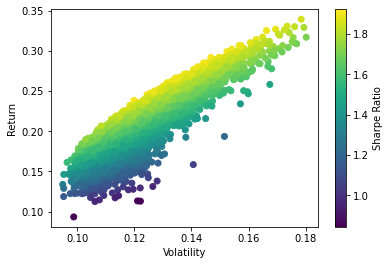

In [17]:
def efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.05):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        p_return, p_std_dev = portfolio_performance(weights,mean_returns,cov_matrix)
        results[0,i] = p_std_dev
        results[1,i] = p_return
        results[2,i] = (p_return - risk_free_rate) / p_std_dev
        weights_record.append(weights)
    return results, weights_record
results, weights_record = efficient_frontier(mean_returns, cov_matrix)
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()

[ 98.9143694  100.99734545 100.2829785 ]


[100.505581    99.77899231  99.36529011]
